# Tugas

## Soal 1

Split      Kernel     Akurasi   
-----------------------------------
70:30      linear     0.9706
70:30      poly       0.9569
70:30      rbf        0.9811
80:20      linear     0.9763
80:20      poly       0.9685
80:20      rbf        0.9826


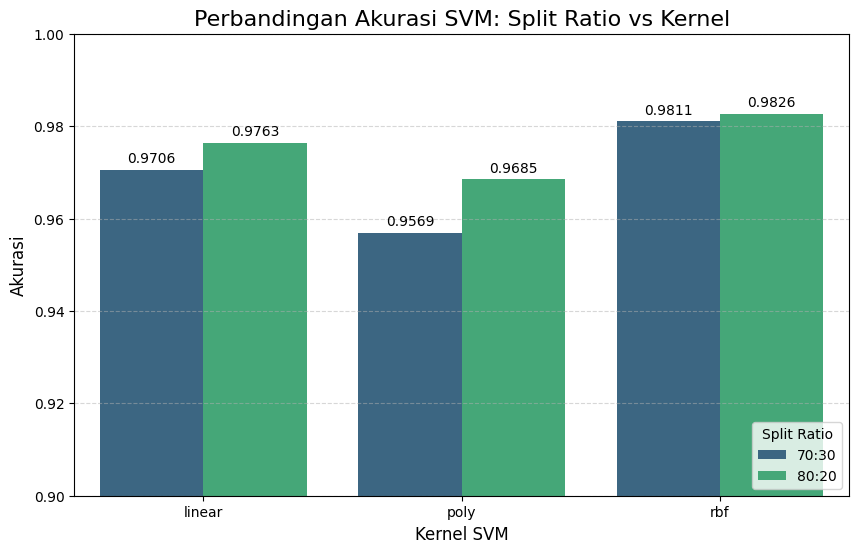

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 1. Load Data
# Sesuaikan path file-mu jika perlu
df = pd.read_csv('/content/drive/MyDrive/Datasets/voice.csv')

# 2. Preprocessing
X = df.drop('label', axis=1)
y = df['label']

le = LabelEncoder()
y = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Definisi Skenario Eksperimen
splits = [0.3, 0.2]  # 0.3 = Split 70:30, 0.2 = Split 80:20
kernels = ['linear', 'poly', 'rbf']

# Variabel untuk menyimpan hasil evaluasi
results = []

print(f"{'Split':<10} {'Kernel':<10} {'Akurasi':<10}")
print("-" * 35)

# 4. Loop Training & Evaluasi
for test_size in splits:
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=42
    )

    ratio_label = "70:30" if test_size == 0.3 else "80:20"

    for kernel in kernels:
        model = SVC(kernel=kernel, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        print(f"{ratio_label:<10} {kernel:<10} {acc:.4f}")

        # Simpan hasil ke dalam list
        results.append({
            'Split Ratio': ratio_label,
            'Kernel': kernel,
            'Akurasi': acc
        })

# 5. Membuat Output Histogram (Grouped Bar Chart)
df_results = pd.DataFrame(results)

plt.figure(figsize=(10, 6))

# Membuat Bar Chart dikelompokkan berdasarkan Split Ratio
ax = sns.barplot(data=df_results, x='Kernel', y='Akurasi', hue='Split Ratio', palette='viridis')

# Mempercantik Grafik
plt.title('Perbandingan Akurasi SVM: Split Ratio vs Kernel', fontsize=16)
plt.xlabel('Kernel SVM', fontsize=12)
plt.ylabel('Akurasi', fontsize=12)
plt.ylim(0.90, 1.0)  # Zoom di area 90%-100% agar perbedaannya terlihat jelas
plt.legend(title='Split Ratio', loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Menambahkan angka di atas batang
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3)

plt.show()

## Soal 2


--- Loading Data ---
Memulai proses loading dan ekstraksi fitur...
Selesai. Total gambar diproses: 400
Dimensi Fitur: 96 (32 bins x 3 warna)

Jumlah Data Training (80%): 320
Jumlah Data Testing  (20%): 80

--- Memulai Grid Search (Hyperparameter Tuning) ---
Mencari kombinasi C dan Gamma terbaik untuk kernel RBF...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel

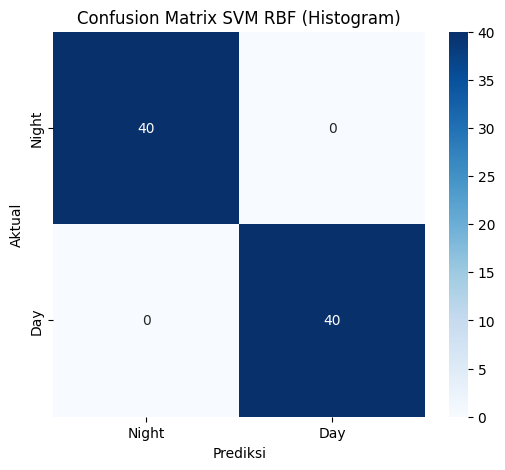

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. KONFIGURASI PATH DATASET
# ==========================================
# Pastikan Google Drive sudah dimount: from google.colab import drive; drive.mount('/content/drive')
# Sesuaikan path ini jika struktur foldermu berbeda sedikit
train_dir = "/content/drive/MyDrive/Datasets/images/images/training/"
test_dir = "/content/drive/MyDrive/Datasets/images/images/test/"

# ==========================================
# 2. FUNGSI EKSTRAKSI FITUR (HISTOGRAM WARNA)
# ==========================================
def extract_histogram_feature(image):
    """
    Mengubah gambar menjadi vektor fitur berdasarkan histogram warna RGB.
    Kita gunakan 32 bin per channel, sehingga total fitur = 32 x 3 = 96.
    """
    # Resize gambar agar komputasi histogram lebih cepat & seragam
    # Ukuran 256x256 cukup detail untuk histogram
    image = cv2.resize(image, (256, 256))

    bins = 32
    hist_features = []
    colors = ('b', 'g', 'r') # OpenCV urutannya BGR

    for i, col in enumerate(colors):
        # Hitung histogram: [image], [channel], mask, [bins], [range]
        hist = cv2.calcHist([image], [i], None, [bins], [0, 256])

        # Normalisasi histogram (SANGAT PENTING untuk SVM)
        # Agar rentang nilainya 0-1 dan tidak mendominasi perhitungan jarak
        cv2.normalize(hist, hist)
        hist_features.extend(hist.flatten())

    return np.array(hist_features)

# ==========================================
# 3. LOAD DATA & PREPROCESSING
# ==========================================
def load_combined_dataset(path_list):
    features = []
    labels = []

    total_files = 0

    print("Memulai proses loading dan ekstraksi fitur...")

    for folder_path in path_list:
        p = Path(folder_path)
        # Loop masuk ke subfolder 'day' dan 'night'
        dirs = p.glob('*')

        for dir in dirs:
            # Ambil label dari nama folder terakhir
            label_str = str(dir).split('/')[-1]

            # Encode Label: day -> 1, night -> 0
            if label_str not in ['day', 'night']:
                continue # Skip jika ada folder nyasar

            label_enc = 1 if label_str == 'day' else 0

            # Loop file jpg
            for file in dir.glob('*.jpg'):
                img = cv2.imread(str(file))

                if img is not None:
                    # Ekstraksi Fitur
                    hist_feat = extract_histogram_feature(img)

                    features.append(hist_feat)
                    labels.append(label_enc)
                    total_files += 1

    print(f"Selesai. Total gambar diproses: {total_files}")
    return np.array(features), np.array(labels)

# Gabungkan kedua folder agar bisa kita split sendiri sesuai rasio 80:20
print("--- Loading Data ---")
X, y = load_combined_dataset([train_dir, test_dir])

# Cek apakah data berhasil terload
if len(X) == 0:
    print("\n[ERROR] Data kosong! Periksa kembali path direktori Anda.")
else:
    print(f"Dimensi Fitur: {X.shape[1]} (32 bins x 3 warna)")

    # ==========================================
    # 4. SPLIT DATA (80:20)
    # ==========================================
    # stratify=y memastikan proporsi day/night seimbang di train & test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nJumlah Data Training (80%): {len(X_train)}")
    print(f"Jumlah Data Testing  (20%): {len(X_test)}")

    # ==========================================
    # 5. HYPERPARAMETER TUNING (SVM RBF)
    # ==========================================
    print("\n--- Memulai Grid Search (Hyperparameter Tuning) ---")
    print("Mencari kombinasi C dan Gamma terbaik untuk kernel RBF...")

    # Parameter Grid
    # C: Mengatur margin error (Kecil = soft margin, Besar = hard margin)
    # Gamma: Mengatur radius pengaruh data (Kecil = luas, Besar = sempit)
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf']
    }

    # Grid Search dengan Cross Validation (cv=5)
    grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
    grid.fit(X_train, y_train)

    # ==========================================
    # 6. EVALUASI DAN HASIL
    # ==========================================
    print("\n" + "="*50)
    print("HASIL AKHIR EXPERIMEN")
    print("="*50)

    # Hasil Tuning
    print(f"Hyperparameter Terbaik: {grid.best_params_}")
    print(f"Skor Validasi Terbaik : {grid.best_score_:.4f}")

    # Evaluasi pada Data Test (20% yang disisihkan)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n>> AKURASI MODEL PADA DATA TEST: {acc:.4f} ({acc*100:.2f}%)")
    print("-" * 50)

    print("\nLaporan Klasifikasi:")
    print(classification_report(y_test, y_pred, target_names=['Night (0)', 'Day (1)']))

    # (Opsional) Visualisasi Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Night', 'Day'], yticklabels=['Night', 'Day'])
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title('Confusion Matrix SVM RBF (Histogram)')
    plt.show()